In [1]:
pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install dtreeviz

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pds
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from collections import Counter
# for cross validation
from sklearn.model_selection import StratifiedKFold #cross-validation splitter
from sklearn.model_selection import cross_validate #cross-validation evaluation of metrics
# for visualising cross validation
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)
# for grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# for decision tree visualisation
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
# for plotting ROC score
from sklearn.metrics import RocCurveDisplay

# visualize the decision tree 
import dtreeviz
from dtreeviz.trees import *
from IPython import display
from IPython.core.display import display, HTML

/tmp/ipykernel_42140/2716215544.py:41: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [6]:
df = pds.read_csv('titanic/train.csv', sep=",")

On supprime les attributs ne nous aidant pas à déterminer qui pourrait être un survivant

In [7]:
X = df.copy()
del X["PassengerId"]
del X["Name"]
del X["Ticket"]

Etudions l'utilité des attributs suivants

In [8]:
del X["Cabin"] # trop peu de passagers ont renseigné leur cabine, on se doit de supprimer la colonne
#del X["Fare"]
del X["Embarked"]

Créons des fonctions permettant de transformer tous nos attributs en données chiffrées

In [9]:
def transform_sex_to_int(X):
    gender=[]
    for element in X['Sex']:
        if element == 'male':
            gender.append(0)
        elif element == "female":
            gender.append(1)
        else:
            gender.append(float('nan'))
            
    X["Sex"]=gender
    return

In [10]:
transform_sex_to_int(X)

Supprimons tous les passagers dont les informations ne sont pas suffisantes

In [11]:
X=X.dropna()
y=X["Survived"]
del X["Survived"]

Créons un jeu de test en piochant 100 éléments de X.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
n_splits=50

Créons notre arbre de décision directement avec du cross validation

In [ ]:
n_splits=50

param_grid = {
    "max_depth": [1,2,3,4,5,6,7,8,9,10,15,20,None],
    "min_samples_split": [1,2,3,4,5,7,8,9,10],
    "min_samples_leaf": [1,2,3,4,5],
    "class_weight":[{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.3,1:0.7},{0:0.4,1:0.6},{0:0.5,1:0.5},{0:0.6,1:0.4},{0:0.7,1:0.3},{0:0.8,1:0.2},{0:0.9,1:0.1}]
}

dt = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(dt, param_grid, scoring="roc_auc", n_jobs=-1, cv=n_splits).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test)))

Le cross validation utilisé par grid search est le suivant (à la seed de randomness près)

In [15]:
cv = StratifiedKFold(n_splits=n_splits, random_state=0, shuffle=True) # mais shuffle est false

Visualisons le cross validation

Utilisons les paramètres trouvés par Grid search dans notre decision tree

In [16]:
dt = DecisionTreeClassifier(random_state=42, class_weight={0: 0.3, 1: 0.7},max_depth= 3, min_samples_leaf= 1, min_samples_split=2)

<Axes: title={'center': 'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

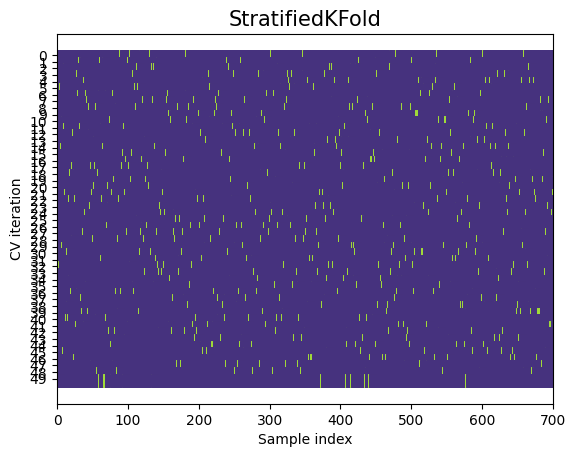

In [17]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )


    # Formatting
    yticklabels = list(range(n_splits)) 
    ax.set(
        yticks=np.arange(n_splits) + 0.2,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits+3, -3],
        xlim=[0, 700],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax
fig, ax = plt.subplots()
plot_cv_indices(cv, X, y, ax, n_splits=n_splits)

In [19]:
dt.fit(X_train,y_train)
y_predict = dt.predict(X_test)
pds.crosstab(y_test,y_predict)

col_0,0,1
Survived,,
0,40,20
1,3,45


In [20]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78        60
           1       0.69      0.94      0.80        48

    accuracy                           0.79       108
   macro avg       0.81      0.80      0.79       108
weighted avg       0.82      0.79      0.79       108



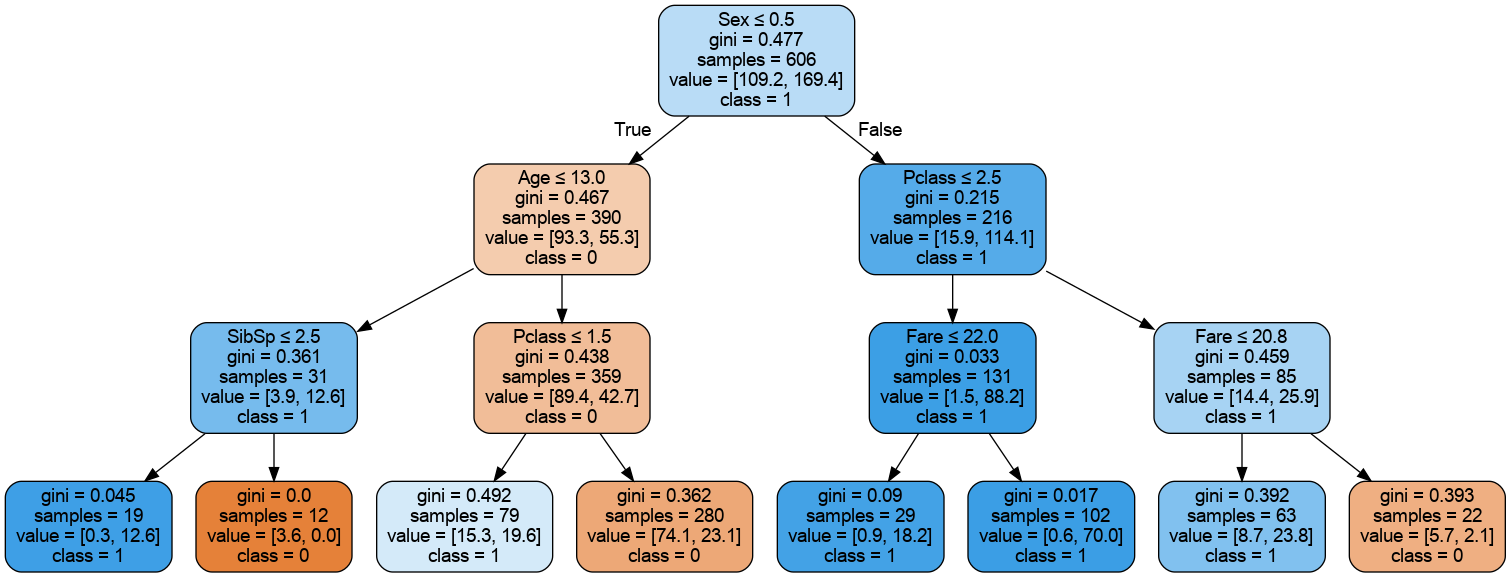

In [21]:
feature_cols=X.columns
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Survival.png')
Image(graph.create_png())

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


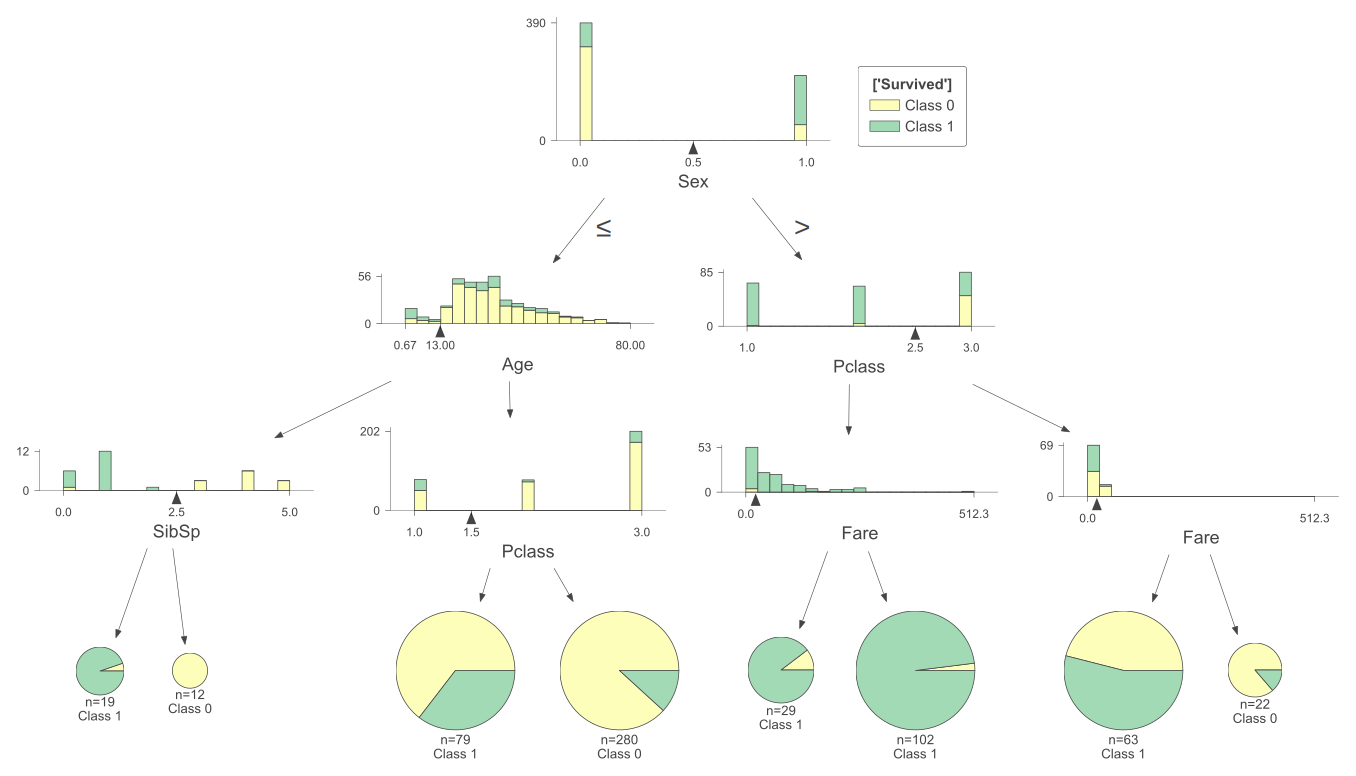

In [30]:
viz_cmodel = dtreeviz.model(dt,
                           tree_index=3,
                           X_train=X_train,
                           y_train=y_train,
                           feature_names=X.columns,
                           target_name=['Survived'])
viz_cmodel.view(scale=2)

In [35]:
rfc_disp = RocCurveDisplay.from_estimator(grid_cv, X_test, y_test)

NameError: name 'grid_cv' is not defined

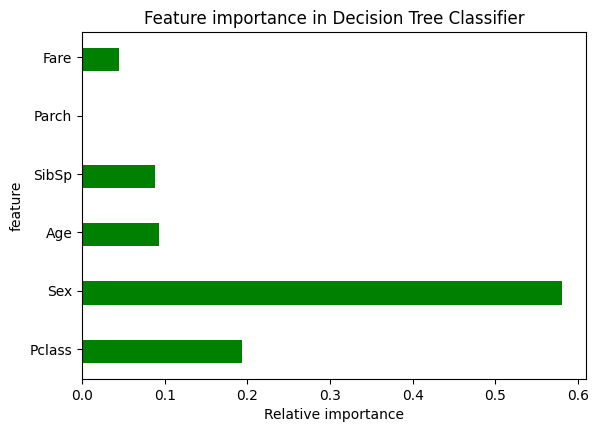

<Figure size 500x500 with 0 Axes>

In [36]:
col = X.columns
fi = dt.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(fi)) # the x locations for the groups
ax.barh(ind, fi, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in Decision Tree Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

Le défaut majeur de l’arbre de décision est que sa performance est fortement dépendante de l’échantillon de données de départ. Par exemple, l’ajout de quelques nouvelles données dans la base d’apprentissage peut modifier radicalement le modèle et les résultats.

Pour lutter contre ce défaut, on utilise alors le "random forest".

Observons si la modifiction de notre échantillon de départ modifie énormément notre arbre de décision.

In [37]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

In [38]:
X_frames=[X_train_2,X_test]
y_frames=[y_train_2,y_test]

In [39]:
X_train_2 = pds.concat(X_frames)
y_train_2 = pds.concat(y_frames)

In [40]:
print(X_train_2.shape,y_train_2.shape)

(623, 6) (623,)


In [41]:
Counter(y_test)

Counter({0: 60, 1: 48})

In [42]:
Counter(y_test_2)

Counter({1: 40, 0: 51})

In [43]:
n_splits=50

param_grid = {
    "max_depth": [1,2,3,4,5,6,7,8,9,10,15,20,None],
    "min_samples_split": [1,2,3,4,5,7,8,9,10],
    "min_samples_leaf": [1,2,3,4,5],
    "class_weight":[{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.3,1:0.7},{0:0.4,1:0.6},{0:0.5,1:0.5},{0:0.6,1:0.4},{0:0.7,1:0.3},{0:0.8,1:0.2},{0:0.9,1:0.1}]
}

dt = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(dt, param_grid, scoring="roc_auc", n_jobs=-1, cv=n_splits).fit(X_train_2, y_train_2)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train_2, grid_cv.predict(X_train_2)))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test_2, grid_cv.predict(X_test_2)))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
29250 fits failed out of a total of 263250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29250 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _va

Param for GS {'class_weight': {0: 0.3, 1: 0.7}, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
CV score for GS 0.8670357142857142
Train AUC ROC Score for GS:  0.8294852546916889
Test AUC ROC Score for GS:  0.8367647058823529


In [47]:
dt_2 = DecisionTreeClassifier(random_state=42,class_weight= {0: 0.3, 1: 0.7}, max_depth= 4, min_samples_leaf= 4, min_samples_split= 2)
dt_2.fit(X_train_2,y_train_2)
y_predict_2 = dt_2.predict(X_test_2)
pds.crosstab(y_test_2,y_predict_2)

col_0,0,1
Survived,,
0,42,9
1,6,34


In [48]:
print(classification_report(y_test_2, y_predict_2))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        51
           1       0.79      0.85      0.82        40

    accuracy                           0.84        91
   macro avg       0.83      0.84      0.83        91
weighted avg       0.84      0.84      0.84        91



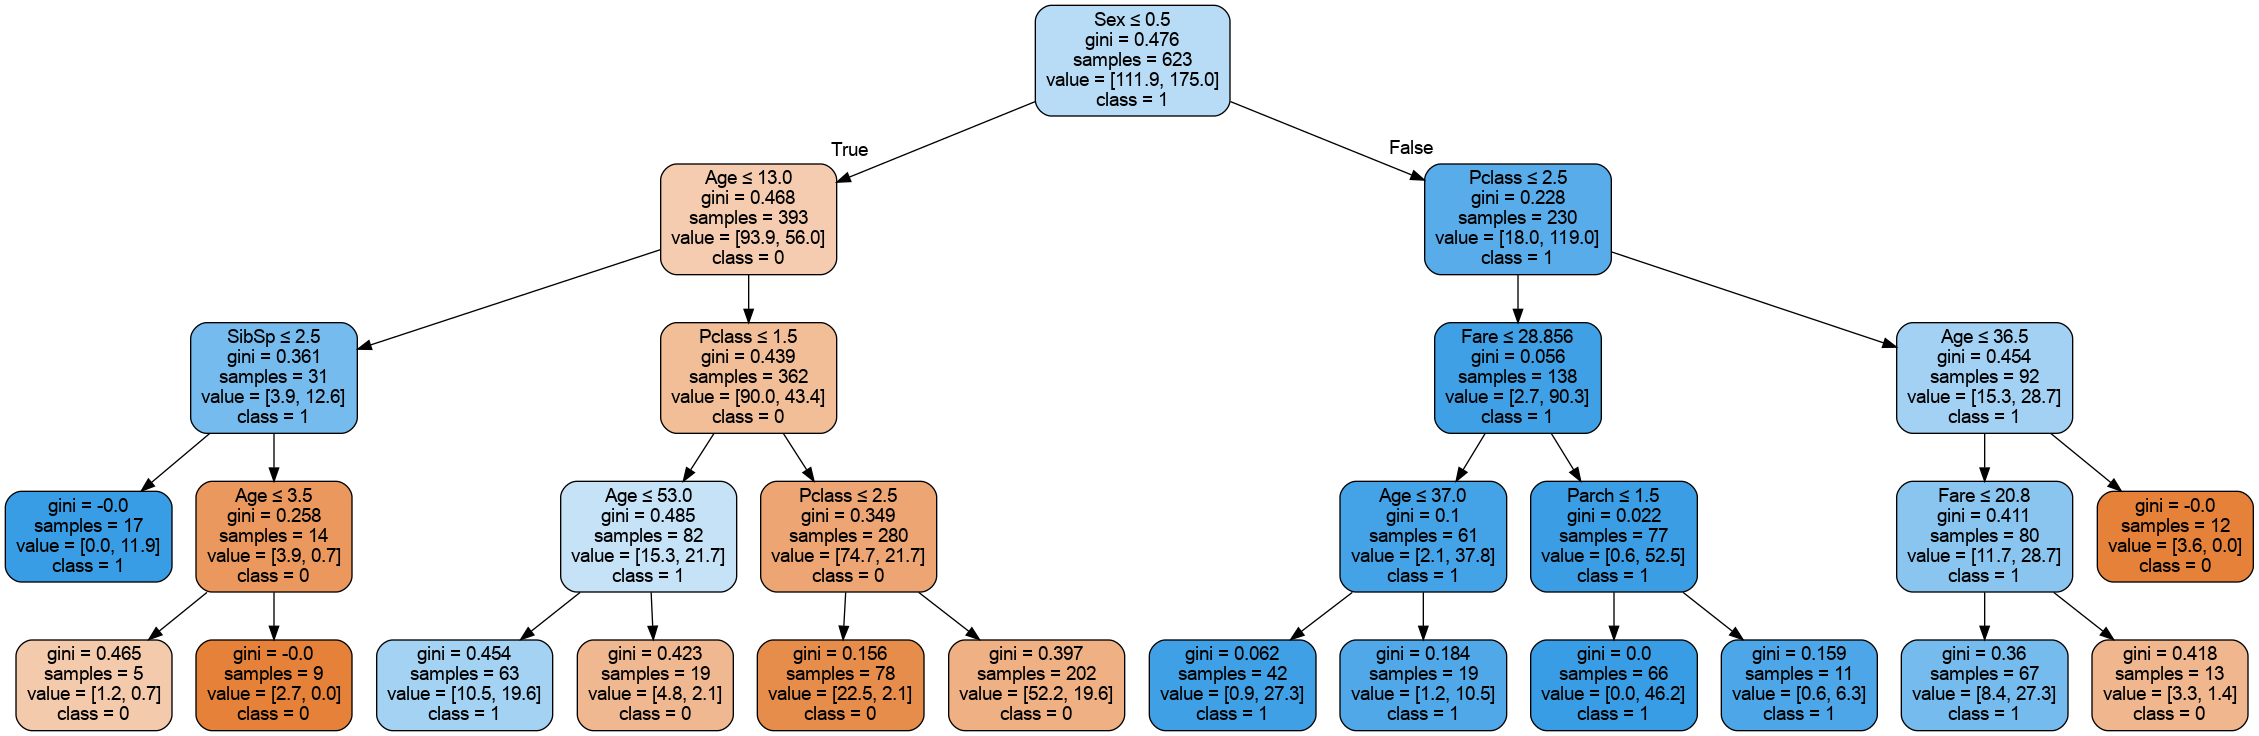

In [49]:
feature_cols=X.columns
dot_data = StringIO()
export_graphviz(dt_2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Survival_2.png')
Image(graph.create_png())

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


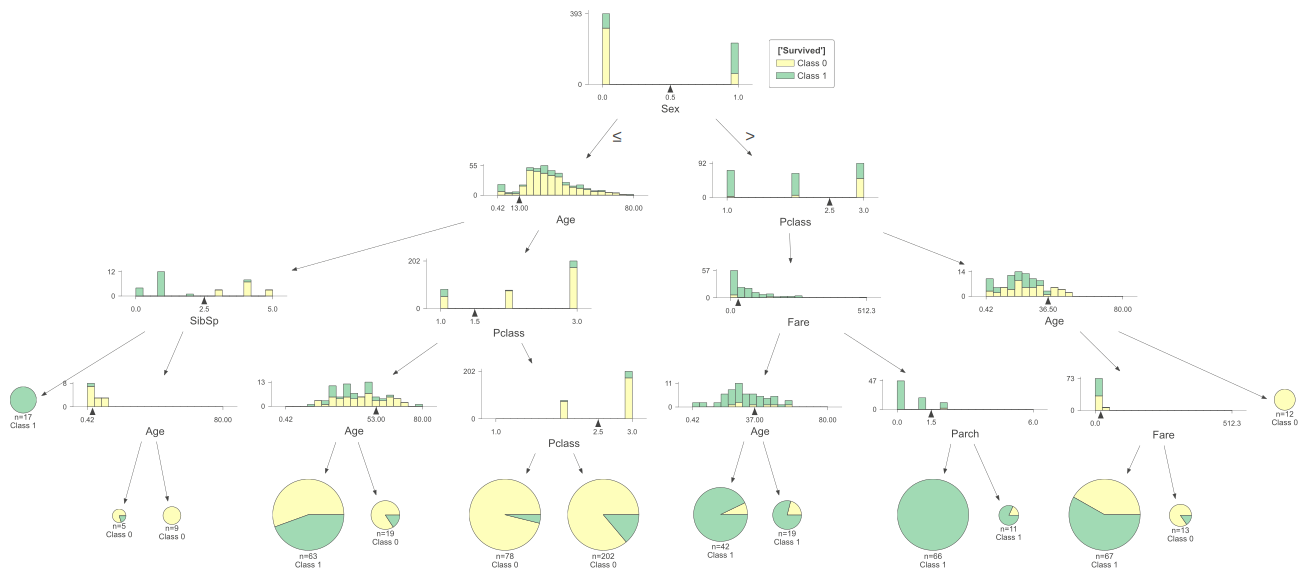

In [52]:
viz_cmodel = dtreeviz.model(dt_2,
                           tree_index=3,
                           X_train=X_train_2,
                           y_train=y_train_2,
                           feature_names=X.columns,
                           target_name=['Survived'])
viz_cmodel.view(scale=1.2)

# Stabilité de notre méthode
Faisons du cross validation et regardons à quel point l'accuracy change en fonction du remaniement

In [55]:
scoring = ['accuracy']
cv = StratifiedKFold(n_splits=30, random_state=10, shuffle=True)
scores = cross_validate(dt, X_train, y_train, scoring=scoring,
                        cv=cv, return_train_score=False)
scores.keys()
print('Global accuracy over all folds: %0.6f (+/- %0.6f)'
      % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))

Global accuracy over all folds: 0.762302 (+/- 0.189206)
